<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>




### Full Name: Amirabbas Afzali
### Student ID: 400100662



# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 188925545.50it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41456431.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 51607278.54it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4238159.90it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [4]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

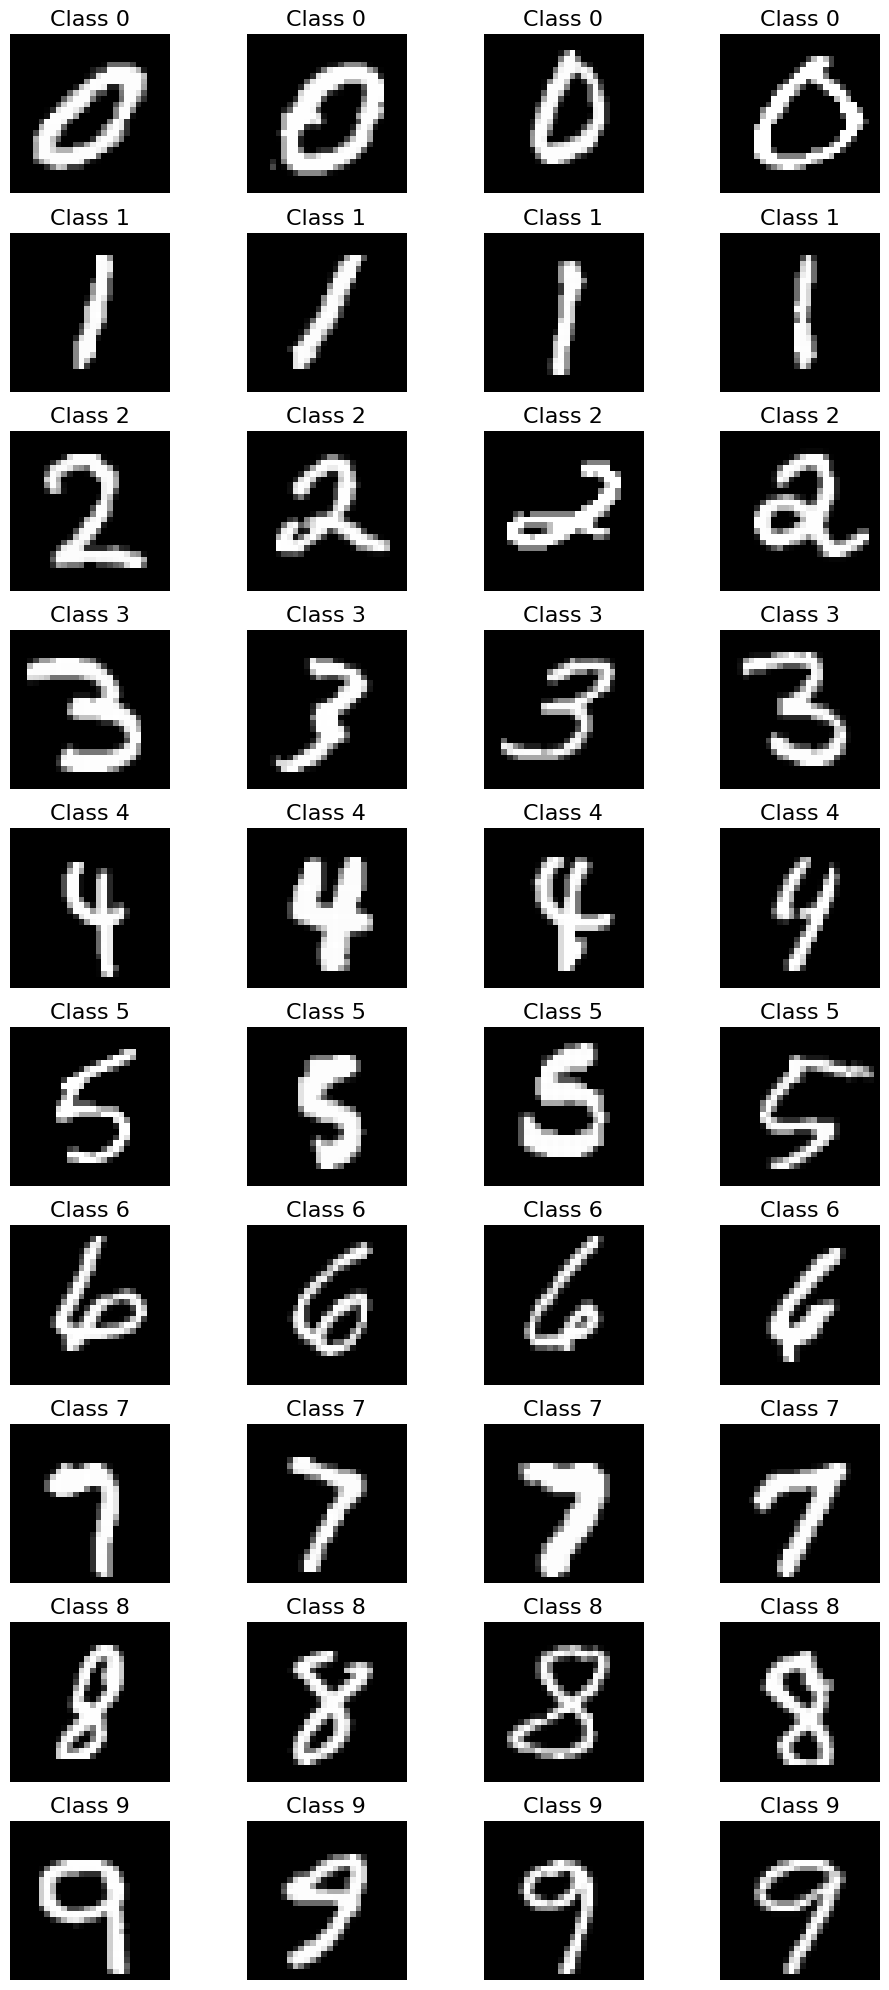

In [5]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [67]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU())

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid())


    def reparameterize(self, mu, logvar):
        """
        We first compute the standard deviation std from the log variance.
        Then, we sample random noise epsilon from a standard normal distribution with
        the same shape as std. Finally,we use the reparameterization trick to obtain
        the latent variable z.
        """
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)  # Computing the standard deviation from the log variance
        epsilon = torch.randn_like(std)  # Sampling random noise from a standard normal distribution
        z = mu + epsilon * std  # transforming the samples to match the desired distribution
        return z

    def forward(self, x):
        # TODO: Implement the forward pass

        encoder = self.encoder(x)
        mu = self.fc_mu(encoder)
        logvar = self.fc_logvar(encoder)

        # latent variable
        z = self.reparameterize(mu, logvar)
        decoder = self.decoder(z)

        return decoder, mu, logvar ,z

$$\ D_{KL}(N(\mu, \Sigma)\parallel N(0, 1)) = -\frac{1}{2} \left(1 + \log\det(\Sigma) -tr(\Sigma) - \mu^T\mu \right) $$


In [68]:
# Define VAE loss function
def vae_loss(recon, data, mu, logvar):
    # Reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5* torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss = reconstruction loss + KL divergence loss
    total_loss = reconstruction_loss + kl_divergence
    return total_loss


In [69]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            optimizer.zero_grad()

            # TODO: Flatten the data and recon tensors
            data = data.view(data.shape[0], -1)
            recon, mu, logvar,_ = model(data)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)

        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, '/content/drive/My Drive/DEEP/HW4/Q2/best_vae_mlp_model.pth')

    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 185.049429679362
Sample Images:


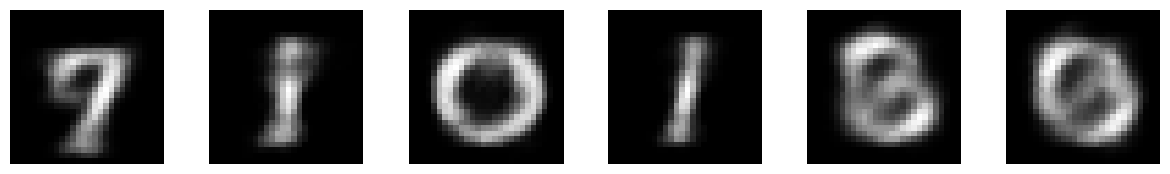


##################################################
VAE-MLP Epoch [2/10], Loss: 159.10108466796876
Sample Images:


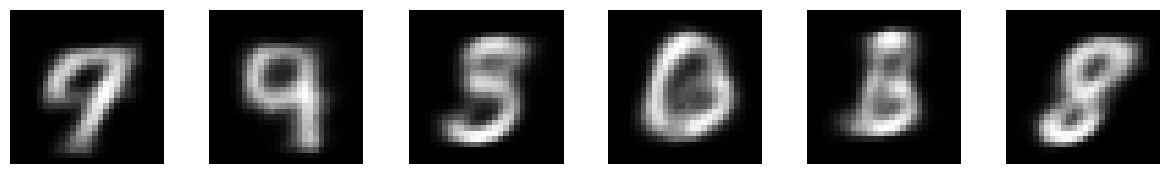


##################################################
VAE-MLP Epoch [3/10], Loss: 153.07403684895834
Sample Images:


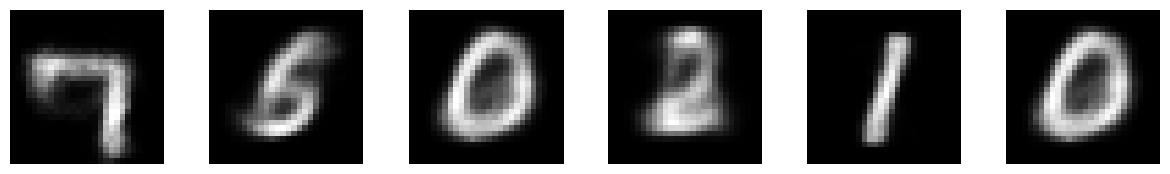


##################################################
VAE-MLP Epoch [4/10], Loss: 150.04172177734375
Sample Images:


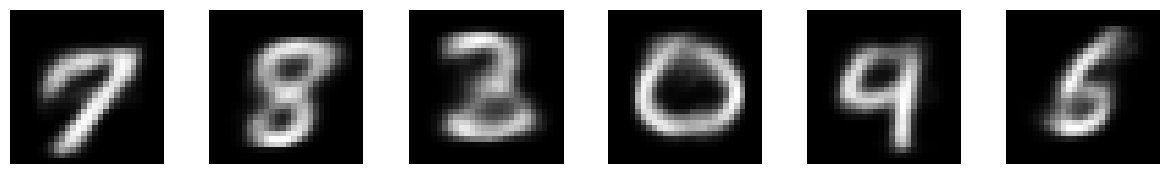


##################################################
VAE-MLP Epoch [5/10], Loss: 148.06990811360677
Sample Images:


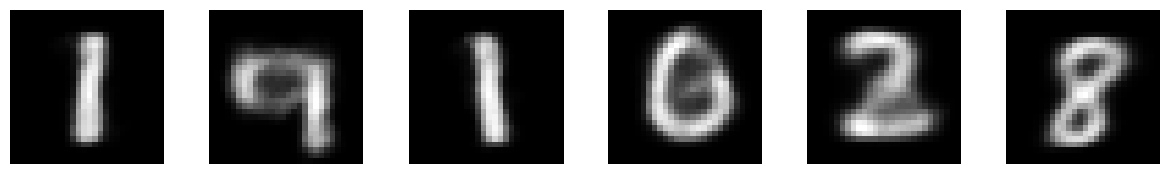


##################################################
VAE-MLP Epoch [6/10], Loss: 146.17011407063802
Sample Images:


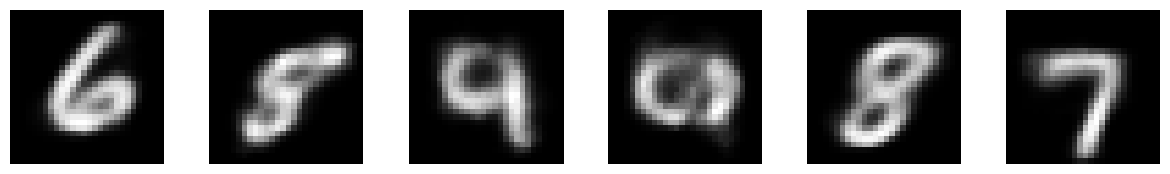


##################################################
VAE-MLP Epoch [7/10], Loss: 145.29609350585937
Sample Images:


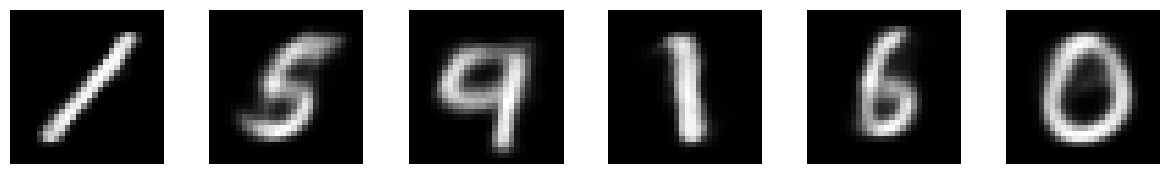


##################################################
VAE-MLP Epoch [8/10], Loss: 143.81972943522135
Sample Images:


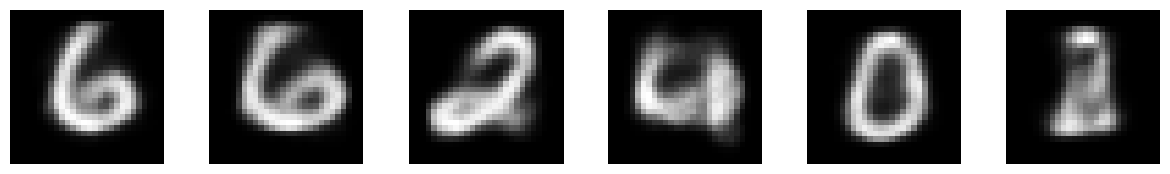


##################################################
VAE-MLP Epoch [9/10], Loss: 143.04373623860678
Sample Images:


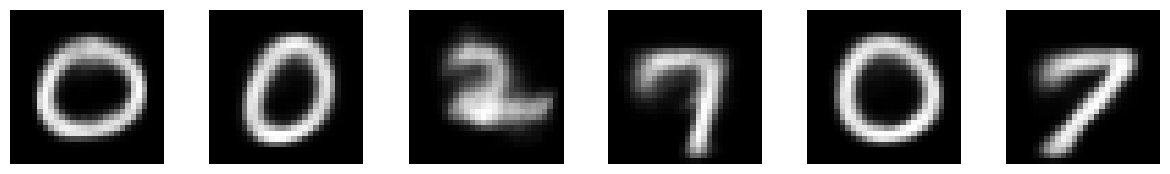


##################################################
VAE-MLP Epoch [10/10], Loss: 142.52425584309896
Sample Images:


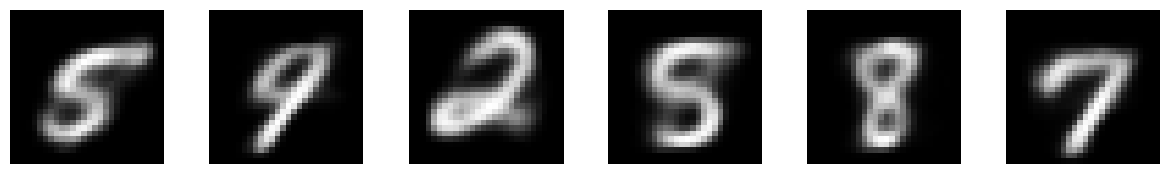

Best model saved as 'best_vae_mlp_model.pth'


In [70]:
# Train VAE-MLP
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [71]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU())

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid())

    def reparameterize(self, mu, logvar):
        """
        We first compute the standard deviation std from the log variance.
        Then, we sample random noise epsilon from a standard normal distribution with
        the same shape as std. Finally,we use the reparameterization trick to obtain
        the latent variable z.
        """
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)  # Computing the standard deviation from the log variance
        epsilon = torch.randn_like(std)  # Sampling random noise from a standard normal distribution
        z = mu + epsilon * std  # transforming the samples to match the desired distribution
        return z


    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], dim=1)

        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        reconstructed = self.decoder(torch.cat([z, y], dim=1))

        return reconstructed, mu, logvar, class_logits, z


In [72]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(data.size(0), -1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = nn.functional.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = nn.functional.cross_entropy(class_logits, labels)

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss

In [73]:
torch.eye(10)[[1,3]]

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [74]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = torch.eye(10)[labels]


            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits,_ = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, '/content/drive/My Drive/DEEP/HW4/Q2/best_cvae_mlp_model.pth')

    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 163.34423088378907
Sample Images:


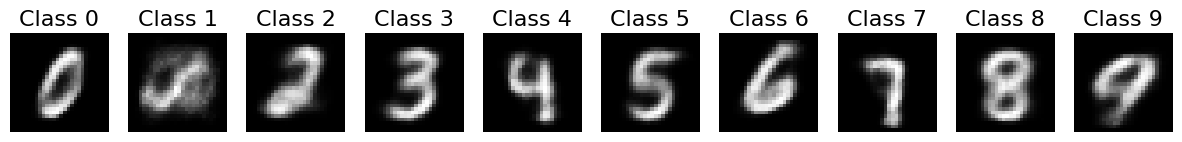


##################################################
CVAE-MLP Epoch [2/10], Loss: 138.5336536783854
Sample Images:


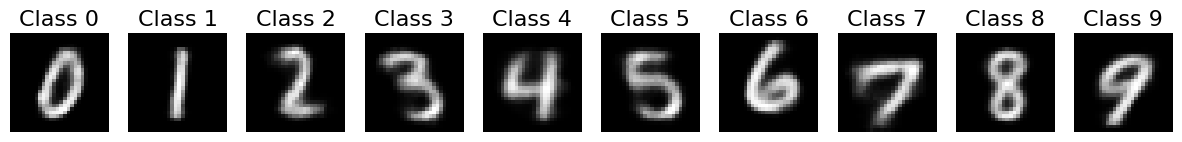


##################################################
CVAE-MLP Epoch [3/10], Loss: 135.2678819498698
Sample Images:


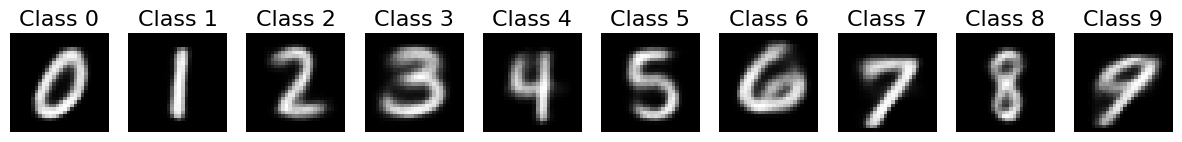


##################################################
CVAE-MLP Epoch [4/10], Loss: 133.60513645019532
Sample Images:


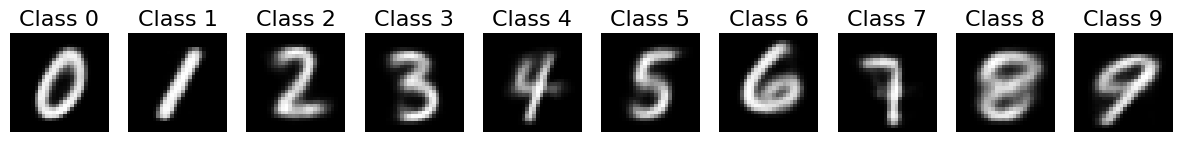


##################################################
CVAE-MLP Epoch [5/10], Loss: 132.59498478597004
Sample Images:


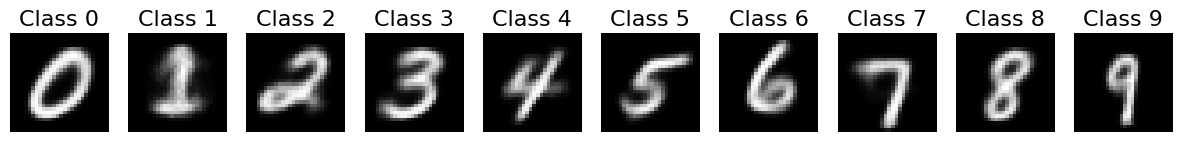


##################################################
CVAE-MLP Epoch [6/10], Loss: 131.81149486490887
Sample Images:


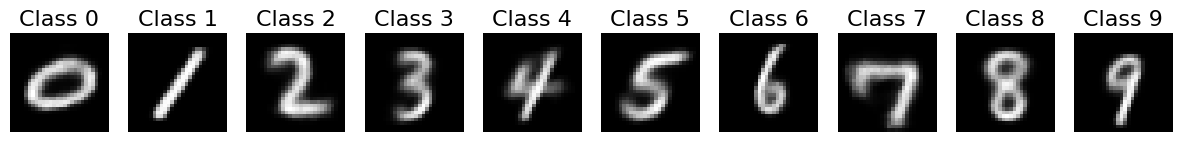


##################################################
CVAE-MLP Epoch [7/10], Loss: 131.184311332194
Sample Images:


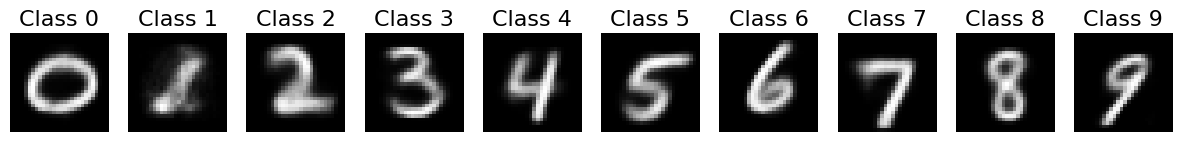


##################################################
CVAE-MLP Epoch [8/10], Loss: 130.59586340332032
Sample Images:


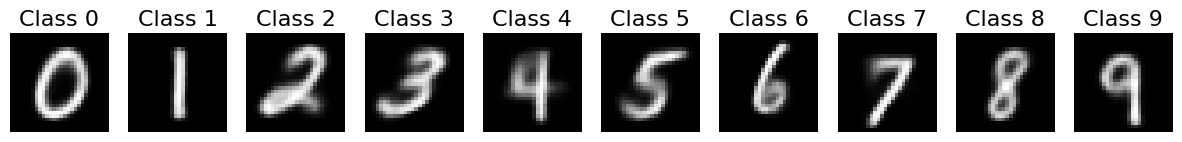


##################################################
CVAE-MLP Epoch [9/10], Loss: 130.24098545735677
Sample Images:


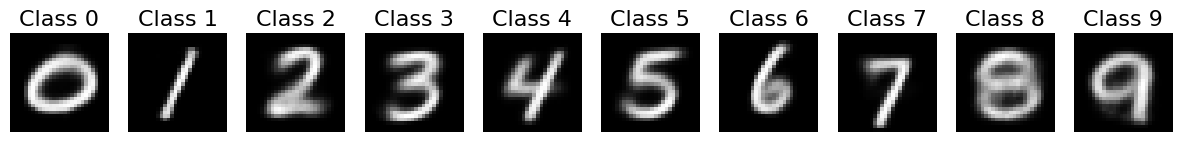


##################################################
CVAE-MLP Epoch [10/10], Loss: 129.83150626627605
Sample Images:


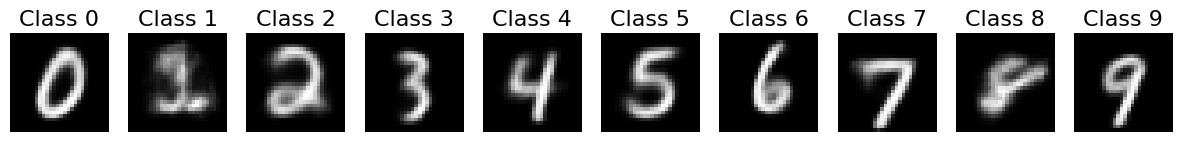

Best model saved as 'best_cvae_mlp_model.pth'


In [75]:
cvae_mlp = CVAE_MLP(784, 256, 2, 10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


## **CVAE (MLP)**

Collect data from dataset :

In [98]:
vae_mlp.eval()

# Extract the latent space representations for some input data
x = []
for index,(data,_) in enumerate(train_loader):
    data = vae_mlp(data.view(data.shape[0],-1))[-1]
    if index == 0:
      x = data
    elif index == 30:
      break
    else:
      x = torch.cat([x,data])

print(x.shape)

torch.Size([1920, 2])


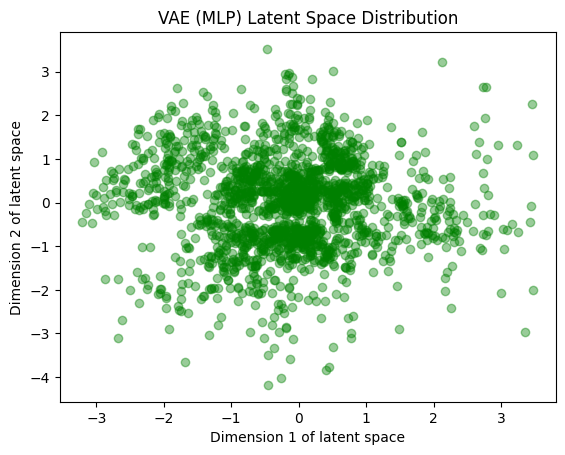

In [99]:
x = x.detach().numpy()
plt.scatter(x[:, 0], x[:, 1], alpha=0.4, c='g')
plt.xlabel('Dimension 1 of latent space')
plt.ylabel('Dimension 2 of latent space')
plt.title('VAE (MLP) Latent Space Distribution')
plt.show()


## **CVAE (MLP)**

In [100]:
cvae_mlp.eval()

# Extract the latent space representations for some input data
x = []
for index,(data,labels) in enumerate(train_loader):
    labels_one_hot = torch.eye(10)[labels]
    data = cvae_mlp(data,labels_one_hot)[-1]
    if index == 0:
      x = data
    elif index == 30:
      break
    else:
      x = torch.cat([x,data])

print(x.shape)

torch.Size([1920, 2])


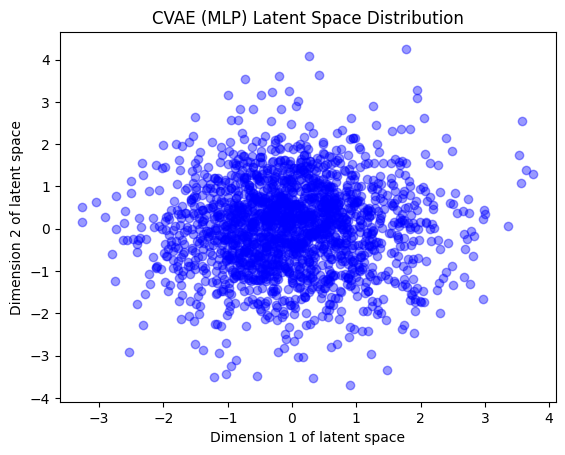

In [101]:
x = x.detach().numpy()
plt.scatter(x[:, 0], x[:, 1], alpha=0.4, c='b')
plt.xlabel('Dimension 1 of latent space')
plt.ylabel('Dimension 2 of latent space')
plt.title('CVAE (MLP) Latent Space Distribution')
plt.show()


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
برای مقایسه ی دو مدل، مشاهده کردیم که عملکرد و همگرایی مدل CVAE ، بهتر می باشد و مقدار loss نهایی کمتری دارد.

در مقایسه ی توضیح latent space  دو مدل با توجه به 1920 نمونه دیتای داده شده به هر مدل و رسم  توضیع دو بعدی z برای هر مدل،
مشاهده می شود که گویا توزیع latent برای VAE ، چند mode در صفحه ی x , y دارد و تویع آن مانند توزیع های mixture می باشد.
و داده های هر کلاس به بخش خاصی از فضای دو بعدی مپ می شود.

ولی در توزیع CVAE ، همچین چیزی مشاهده نمی شود و و توزیع آن مانند یک توزیع
multivariate normal distribution
می باشد. همچنین می توان این طور برداشت کرد که dimention1 و dimention2  از latent space  در این توزیع ، با  یکدیگر uncorrelated هستند.
</font></div>

# **END :/**